# Machine Learning
 
**Autori:** Erik Matovič a Simon Kokavec   
**Číslo datasetu:** 165  
**Percentuálny podiel:** 50/50

## 0. Importovanie

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import math
from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

### Zadanie  
   - Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
   
   - Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátora pomocou metrík accuracy, precision a recall.

### Riešenie  

#### Načítanie datasetov



In [ ]:
df_train = pd.read_csv('../../data/train.csv', sep=',')
df_test = pd.read_csv('../../data/test.csv', sep=',')
df_train.head()

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,age,race
0,0.240147,1.215254,-0.386530,-1.324705,1.012197,-0.085403,0.979523,1.0,-1.189322,-0.749305,1.0,-0.866056,-0.007817,1.0,-0.400413,0.0,2.0,-1.036721,4.0
1,-0.775564,-0.651757,-1.060210,-1.772392,-0.354930,0.556809,1.128525,1.0,-0.534179,1.053322,0.0,-0.461494,-0.660851,0.0,-0.982859,0.0,1.0,-0.347098,1.0
2,0.225980,0.146206,-1.423915,2.480386,2.024872,-1.036218,0.509456,3.0,-0.748730,0.590570,0.0,0.088501,-0.318734,0.0,2.696982,1.0,8.0,1.679314,1.0
3,-1.761756,-1.509458,0.289679,1.369844,0.516427,-0.677995,-1.674788,1.0,-0.993768,-0.292905,0.0,-0.324790,-2.056547,0.0,-0.025407,0.0,3.0,-1.166164,1.0
4,0.298584,-0.571938,0.519505,0.914422,-0.972209,2.060500,0.990801,3.0,-0.893681,0.048618,0.0,-0.484866,0.030176,0.0,-0.822366,0.0,3.0,1.161745,2.0


### Upravenie testovacieho datasetu na základe Fázy 2

In [ ]:
import preprocessing

pipeline_obj2 = Pipeline([
        ('Transformer_scal', preprocessing.ScalingTransform(df_test, 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv','alt', 'hematokrit','age', 'erytrocyty')),
        ('Transformer_yeo', preprocessing.PowerTransform(df_test, 'yeo-johnson', 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv', 'alt','hematokrit','age', 'erytrocyty'))

])

train_final = pipeline_obj2.transform(df_test) 

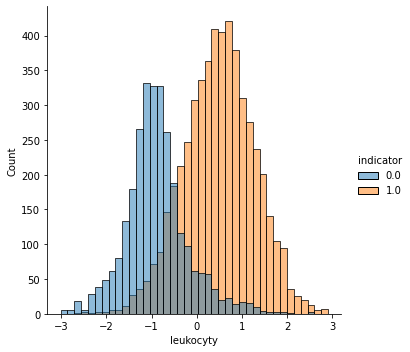

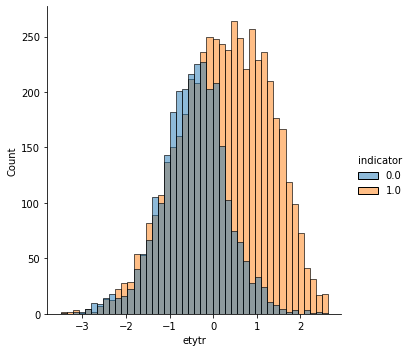

In [ ]:
#Leukocyty hraničná -0.5 presnejšie -0.43 až -0,29
#Etytr hraničná -0.15

print(sns.displot(x = "leukocyty", hue = "indicator", data = df_train))
print(sns.displot(x = "etytr", hue = "indicator", data = df_train))

## 1R (Maybe XR) Algo - uvidíme jak sa bude dariť

In [ ]:
import operator

communism = [ [(("leukocyty", -0.5), operator.lt)],
          [(("etytr",  -0.25), operator.lt)]]

In [ ]:
rules = dict()

- accuracy: (TP + TN) / total population
- precision: TP / (FP + TP)
- recall: TP / (FN + TP) 

In [20]:
def oner_1rule(data, key):
    temp = data[data['indicator'].notna()]
    rules[key] = dict()
    rules[key]["total"] = temp['indicator'].count()
    rules[key]["tp"] = len(temp.loc[(temp.leukocyty >= -0.36) & (temp['indicator'] == 1.0), 'indicator'])
    rules[key]["tn"] = len(temp.loc[(temp.leukocyty < -0.36) & (temp['indicator'] == 0.0), 'indicator'])
    rules[key]["fp"] = len(temp.loc[(temp.leukocyty >= -0.36) & (temp['indicator'] == 0.0), 'indicator'])
    rules[key]["fn"] = len(temp.loc[(temp.leukocyty < -0.36) & (temp['indicator'] == 1.0), 'indicator'])
    return rules
    

In [58]:
def oner_1rule(data):
    rules = dict()
    rules["total"] = data['indicator'].count()
    rules["tp"] = len(data.loc[(data.leukocyty >= -0.36) & (data['indicator'] == 1.0), 'indicator'])
    rules["tn"] = len(data.loc[(data.leukocyty < -0.36) & (data['indicator'] == 0.0), 'indicator'])
    rules["fp"] = len(data.loc[(data.leukocyty >= -0.36) & (data['indicator'] == 0.0), 'indicator'])
    rules["fn"] = len(data.loc[(data.leukocyty < -0.36) & (data['indicator'] == 1.0), 'indicator'])
    return rules
    

In [59]:
def printer(rules):
    print("Accuracy: ",(rules["tp"] + rules["tn"]) / rules["total"])
    print("Precision: ", rules["tp"] / (rules["fp"] + rules["tp"]))
    print("Recall: ", rules["tp"] / (rules["fn"] + rules["tp"]))

In [60]:
result = oner_1rule(df_train)
printer(result)

Accuracy:  0.8511459890383657
Precision:  0.9037487335359676
Recall:  0.861003861003861


In [29]:
result = oner_1rule(train_final)
printer(result)

Accuracy:  0.8460388639760837
Precision:  0.8904448105436573
Recall:  0.8599840891010342


<AxesSubplot:xlabel='etytr', ylabel='leukocyty'>

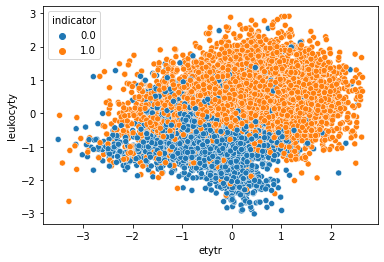

In [30]:
sns.scatterplot(y="leukocyty", x="etytr", hue="indicator", data=df_train)

In [66]:
def oner_2rule(data):
    rules = dict()
    rules["total"] = data['indicator'].count()
    rules["tp"] = len(data.loc[((data.leukocyty >= -0.36) & (data.etytr <= -0.15)) & (data['indicator'] == 1.0), 'indicator'])
    rules["tn"] = len(data.loc[((data.leukocyty < -0.36) | (data.etytr > -0.15)) & (data['indicator'] == 0.0), 'indicator'])
    rules["fp"] = len(data.loc[((data.leukocyty >= -0.36) & (data.etytr <= -0.15)) & (data['indicator'] == 0.0), 'indicator'])
    rules["fn"] = len(data.loc[((data.leukocyty < -0.36) | (data.etytr > -0.15)) & (data['indicator'] == 1.0), 'indicator'])
    return rules

In [67]:
result = oner_2rule(df_train)
printer(result)

Accuracy:  0.4879172894867962
Precision:  0.7974401780745687
Recall:  0.27664092664092665


In [63]:
result = oner_2rule(train_final)
printer(result)

Accuracy:  0.6776283009466866
Precision:  0.9045092838196287
Recall:  0.5425616547334925


## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia

### Zadanie  
   - Na trénovanie využite minimálne jeden stromový algoritm strojového učenia v scikit-learn.
   - Vizualizujte natrénované pravidlá.
   - Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
   - Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.

### Riešenie  

## Tree - Gini

In [51]:
df_prepared = df_train.drop(columns=["indicator"])

model = tree.DecisionTreeClassifier(criterion="gini", max_depth=5)
model = model.fit(df_prepared, df_train["indicator"])

data_tree = model.predict(df_prepared)

print("Accuracy: ",accuracy_score(data_tree, df_train["indicator"]))
print("Precission: ", precision_score(data_tree, df_train["indicator"]))
print("Recall: ", recall_score(data_tree, df_train["indicator"]))

Accuracy:  0.952914798206278
Precission:  0.9664092664092664
Recall:  0.9608445297504798


## Tree - Entropy

In [50]:
df_prepared = df_train.drop(columns=["indicator"])

model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model = model.fit(df_prepared, df_train["indicator"])

data_tree = model.predict(df_prepared)

print("Accuracy: ",accuracy_score(data_tree, df_train["indicator"]))
print("Precission: ",precision_score(data_tree, df_train["indicator"]))
print("Recall: ",recall_score(data_tree, df_train["indicator"]))

Accuracy:  0.9500498256103638
Precission:  0.9698841698841699
Recall:  0.9535016132093377


## 3. Optimalizácia - hyperparameter tuning

### Zadanie  
- Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
- Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

### Riešenie  

In [ ]:
parameters = {'criterion': ('gini','entropy'), 'splitter': ('best','random'), 'max_depth': range(2,20), 'max_features':range(1,77,5)}
# 10-nasobna cross validacia
optimization = GridSearchCV(clf, parameters,cv=10)
vysledok = optimization.fit(df_train_class, train_labels)
vysledok

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### Zadanie  
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 
- Stratégie riešenia chýbajúcich hodnôt a outlierov;
- Scaling resp. transformer či zlepší accuracy klasifikácie;
- Výber atribútov a výber algoritmov;
- Hyperparameter tuning resp. ensemble learning.

Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.


### Riešenie  